In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [20]:
df = pd.read_csv("supply_chain_dataset1.csv")   # or original Kaggle dataset
df["Date"] = pd.to_datetime(df["Date"])

sku = df["SKU_ID"].unique()[0]
df = df[df["SKU_ID"] == sku].sort_values("Date")

In [21]:
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek

# Select generalized features only
features = [
    "Units_Sold",
    "Promotion_Flag",
    "Supplier_Lead_Time_Days",
    "Month",
    "DayOfWeek",
    "Region"
]

df = df[features].dropna()

In [22]:
df = pd.get_dummies(df, columns=["Region"], drop_first=True)

In [23]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

In [24]:
def create_sequences(data, seq_length, target_col=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col])  # Units_Sold
    return np.array(X), np.array(y)

SEQ_LENGTH = 30   # past 30 days → next day

X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [25]:

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [26]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

c:\Users\Guest 1\Desktop\ttl-agentic-ai\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0362 - val_loss: 0.0158
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0120 - val_loss: 0.0172
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0113 - val_loss: 0.0173
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0116 - val_loss: 0.0176
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0111 - val_loss: 0.0158
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0112 - val_loss: 0.0148
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - val_loss: 0.0169
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - val_loss: 0.0119
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [28]:
pred_scaled = model.predict(X_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [29]:
# Build dummy array to inverse scale correctly
dummy_pred = np.zeros((len(pred_scaled), scaled_data.shape[1]))
dummy_pred[:, 0] = pred_scaled.flatten()

dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 0] = y_test

pred = scaler.inverse_transform(dummy_pred)[:, 0]
actual = scaler.inverse_transform(dummy_actual)[:, 0]

In [30]:
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
#mape = np.mean(np.abs((actual - pred) / actual)) * 100
smape = np.mean(
    2 * np.abs(actual - pred) / (np.abs(actual) + np.abs(pred) + 1e-8)
) * 100


print("LSTM Model Performance")
print("----------------------")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"SMAPE  : {smape:.2f}%")

LSTM Model Performance
----------------------
MAE   : 5.06
RMSE  : 6.40
SMAPE  : 37.89%


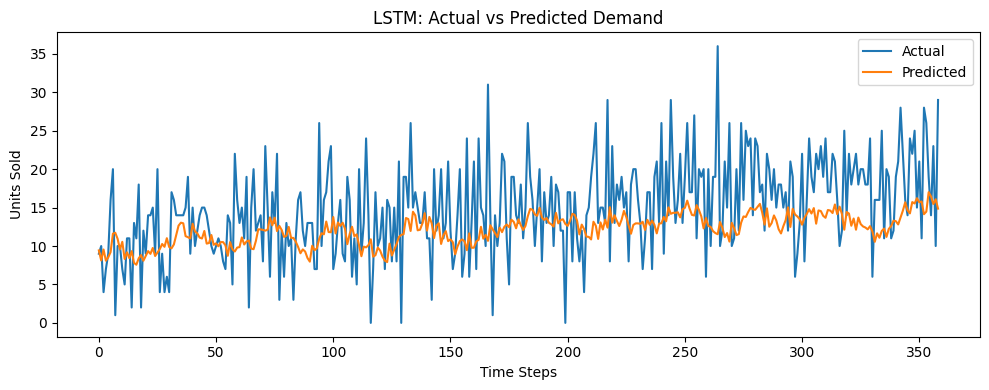

In [31]:
plt.figure(figsize=(10,4))
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Units Sold")
plt.title("LSTM: Actual vs Predicted Demand")
plt.tight_layout()
plt.show()

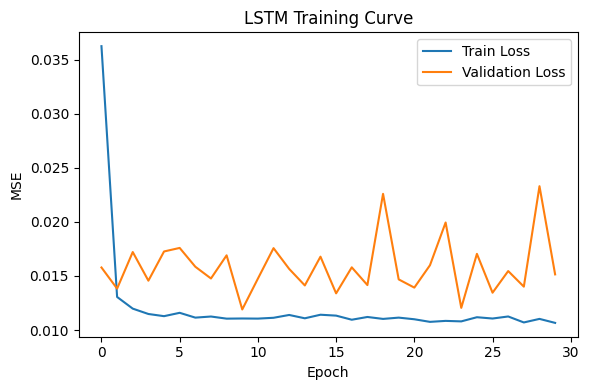

In [32]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("LSTM Training Curve")
plt.tight_layout()
plt.show()

Baseline RMSE: 6.40

Permutation Feature Importance (LSTM):
                         RMSE Increase
Units_Sold                    0.482739
Region_North                  0.128556
Supplier_Lead_Time_Days       0.022363
DayOfWeek                     0.010755
Region_South                 -0.002375
Promotion_Flag               -0.013071
Region_West                  -0.057055
Month                        -0.092034


<Figure size 800x500 with 0 Axes>

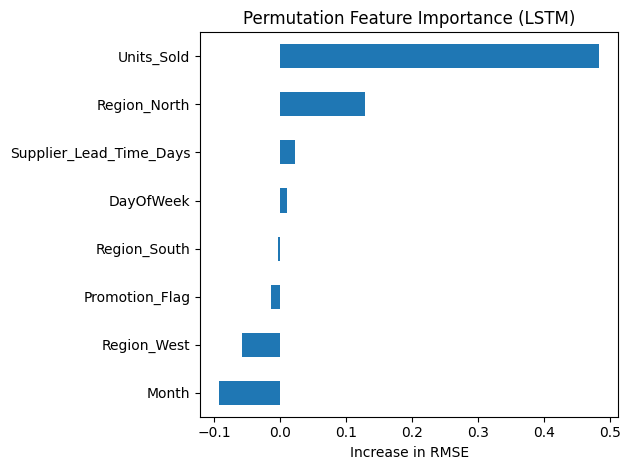

In [33]:
# ============================================
# Permutation Feature Importance for LSTM
# ============================================

from sklearn.metrics import mean_squared_error
import copy

# Feature names (order MUST match model input)
feature_names = df.columns.tolist()

# Function to compute RMSE
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---- Baseline prediction ----
baseline_pred_scaled = model.predict(X_test, verbose=0)

# inverse scale baseline prediction
dummy = np.zeros((len(baseline_pred_scaled), len(feature_names)))
dummy[:, 0] = baseline_pred_scaled.flatten()
baseline_pred = scaler.inverse_transform(dummy)[:, 0]

dummy_actual = np.zeros((len(y_test), len(feature_names)))
dummy_actual[:, 0] = y_test
actual = scaler.inverse_transform(dummy_actual)[:, 0]

baseline_rmse = compute_rmse(actual, baseline_pred)

print(f"Baseline RMSE: {baseline_rmse:.2f}")

# ---- Permutation importance ----
importances = {}

for feature_idx, feature_name in enumerate(feature_names):
    
    X_permuted = copy.deepcopy(X_test)

    # Shuffle feature across all sequences & time steps
    shuffled_values = X_permuted[:, :, feature_idx].flatten()
    np.random.shuffle(shuffled_values)
    X_permuted[:, :, feature_idx] = shuffled_values.reshape(
        X_permuted[:, :, feature_idx].shape
    )

    # Predict with shuffled feature
    perm_pred_scaled = model.predict(X_permuted, verbose=0)

    dummy = np.zeros((len(perm_pred_scaled), len(feature_names)))
    dummy[:, 0] = perm_pred_scaled.flatten()
    perm_pred = scaler.inverse_transform(dummy)[:, 0]

    perm_rmse = compute_rmse(actual, perm_pred)

    importances[feature_name] = perm_rmse - baseline_rmse

# ---- Convert to DataFrame ----
importance_df = (
    pd.DataFrame.from_dict(importances, orient="index", columns=["RMSE Increase"])
    .sort_values("RMSE Increase", ascending=False)
)

print("\nPermutation Feature Importance (LSTM):")
print(importance_df)

# ---- Plot ----
plt.figure(figsize=(8,5))
importance_df.head(10).plot(kind="barh", legend=False)
plt.gca().invert_yaxis()
plt.xlabel("Increase in RMSE")
plt.title("Permutation Feature Importance (LSTM)")
plt.tight_layout()
plt.show()
